#### **Formulating mTSP through MTZ**

MTZ is being selected as the family of Subtour Elimination Constraints (SECs) posed by alternative popular formulations such as DFJ as constraints of DFJ increase exponentially with increasing number of nodes (Bektas, 2006).

**Define a binary variable indicating if an arc is used or unused in a tour:**

$$x_{ij} = 1$$

if arc $(i,j)$ is used on the specific tour, and: 

$$x_{ij} = 0$$

if arc $(i,j)$ is not used on the specific tour.

**Minimize the sum of the cost of the tour:**

$$ minimize \: \Sigma^n_{i=1}\Sigma^n_{j=1} c_{ij}x_{ij}$$

where $C = c_{ij}$ is some distance matrix associated with a set of arcs between the potential "cities" of the mTSP problem

$$s.t. \\ \Sigma^n_{j=1}x_{1j}=m$$

where $m$ is the number of salesmen in the problem. We want $m$ salesmen to leave the initial depot. Essentially we are guaranteeing that this is the single depot version of the problem; maybe this is worth revisiting later on.

**Ensure that m salesmen come back:**

$$\Sigma^n_{j=1}x_{j1}=m$$

**Only one connection is allowed from some city i to some other (non-starting) city j:**

$$\Sigma^n_{i=1}x_{ij}=1, \: j=2,...,n$$

If we don't do this we would allow stuff like multiple routes going from one city to another. This is not good.

**Only one connection is allowed from some city j to some other (non-starting) city i:**

$$\Sigma^n_{j=1}x_{ij}=1, \: i=2,...,n$$

If we don't do this we would allow stuff like multiple routes going from one city to another. This is not good. Combination of last two also prevents things like creating cyclical routes where we go around different cities repeatedly in a circle.

**Make sure everything belongs to the proper set of arcs, make sure no unexpected variable assignments occur:**

$$x_{ij} \in \{0,1\}, \: \forall(i,j) \in A$$

**Subtour elimination constraints:**

We're gonna use MTZ here because it makes for a less complex encoding, though do note that DFJ is a "stronger" formulation, boiling down to having a smaller solution space. Why? I don't really know. Don't ask my why I could not tell you. Anyways:

**SEC FOR mTSP:**

$$u_i - u_j + px_{ij} \leq p - 1$$

p denotes maximum number of nodes which can be visited by a salesman. Node potentials (u's) denote the particular order of visitation. Think of $u_i$ as the node we're on, and $u_j$ as the node we are going to next. Obviously, $u_j$ must be above $u_i$, otherwise the path would "connect in on itself", creating a subtour/cycle. Note that the depot does not have an assigned $u_i$ at the beginning, as that would result in it being impossible for the salesman to return back to the depot.

The above can also be denoted as:

$$u_1 = 1$$
$$\forall i \neq 1: \: 2 \leq u_i \leq n$$
$$\forall \neq 1, \forall j \neq 1 : \: u_i - u_j + 1 \leq (n-1)(1-x_{ij})$$

if $x_{ij} = 1$, i.e. the tour does actually get used, then:

$$u_j \geq u_i + 1$$

This is pretty much exactly what we want. Consider the other case, where $x_{ij} = 0$

$$u_i - u_j + 1 \leq n - 1$$

This is also correct, since we know that the largest difference between two indexes of any (non-depot) nodes does equal to $n - 1$

i.e. if there are ten nodes, the maximum difference between the nodes is 9.

In [65]:
# imports
import random
import gurobipy as grb
import numpy as np
import math
import re

#important global params.
n_cities = 25
n_salesmen = 5

In [66]:
# Generate set of random points deterministically => straightforward.
def generate_random_coordinates(num_points, seed = 100):
    random.seed(seed)
    coordinates = [(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(num_points)]
    return coordinates

In [67]:
# Generate distance matrix
points = generate_random_coordinates(num_points=n_cities)

C = np.zeros((n_cities,n_cities))

for i in range(0, n_cities):
    for j in range(0, len(points)):
        C[i,j] = math.dist(points[i], points[j])

In [68]:
# Set the relevant ranges
set_I = range(0, n_cities)
set_J = range(0, n_cities)

# Transform the problem into a tuplelist -> basically creates a graph of all possible connections
#tuple_list_graph = grb.tuplelist([(i, j) for i in set_I for j in set_I if i != j])

# Set up a Gurobi optimizer, name it accordingly.
opt_model = grb.Model(name="mTSP Optimizer")

# X, denoting if a route is used or not, is a binary variable. Sets up our connection of matrices.
x_vars  ={(i,j):opt_model.addVar(vtype=grb.GRB.BINARY,
                        lb=0, 
                        ub= n_cities,
                        name="x_{0}_{1}".format(i,j))
                        for i in set_I for j in set_J} 

# u variables, tracking order of different visited nodes.
u_vars  = opt_model.addVars(set_I, vtype=grb.GRB.INTEGER, lb=0)

# The constraints - naming conventions follow Bektas, 2006 - Problem code:
opt_model.addConstr(grb.quicksum([x_vars[0, i] for i in range(1, n_cities)]) == n_salesmen)

opt_model.addConstr(grb.quicksum([x_vars[i, 0] for i in range(1, n_cities)]) == n_salesmen)

for j in range(1, n_cities):
    opt_model.addConstr(grb.quicksum(x_vars[i, j] for i in range(n_cities) if i != j) == 1)

for i in range(1, n_cities):
    opt_model.addConstr(grb.quicksum(x_vars[i, j] for j in range(n_cities) if i != j) == 1)

# The main SEC constraint:
for i, j in x_vars:
    if (i != 0 and j != 0):
        opt_model.addConstr(u_vars[i] - u_vars[j] + n_cities * x_vars[i, j] <= n_cities - 1)

#opt_model.addConstr(u_vars[0] == 1)

# This is the worst way of expressing this known to mankind - but whatever.
opt_model.setObjective(grb.quicksum([C[i][j] * x_vars[i, j] for i, j in x_vars]), grb.GRB.MINIMIZE)

# Now optimize the model
opt_model.optimize()


print('The optimal objective is %g' % opt_model.objVal)
result = {e: x_vars[e].X for e in x_vars}
print(result)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700K, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 626 rows, 650 columns and 2880 nonzeros
Model fingerprint: 0x24b245b3
Variable types: 0 continuous, 650 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [3e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 31.7177700
Presolve removed 24 rows and 26 columns
Presolve time: 0.00s
Presolved: 602 rows, 624 columns, 2856 nonzeros
Variable types: 0 continuous, 624 integer (600 binary)

Root relaxation: objective 1.226129e+01, 103 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

     0     0   13.00970    0   62   13.22145   13.00970  1.60%     -    0s
H    0     0                      13.0672855   13.00970  0.44%     -    0s
     0     0   13.00970    0   62   13.06729   13.00970  0.44%     -    0s
     0     0   13.06234    0   44   13.06729   13.06234  0.04%     -    0s
     0     0   13.06234    0   28   13.06729   13.06234  0.04%     -    0s
     0     0   13.06234    0   33   13.06729   13.06234  0.04%     -    0s
     0     0   13.06234    0   30   13.06729   13.06234  0.04%     -    0s
H    0     0                      13.0623351   13.06234  0.00%     -    0s

Cutting planes:
  Learned: 6
  Gomory: 4
  Implied bound: 7
  Clique: 1
  MIR: 9
  Zero half: 2

Explored 1 nodes (520 simplex iterations) in 0.15 seconds (0.09 work units)
Thread count was 20 (of 20 available processors)

Solution count 10: 13.0623 13.0673 13.2214 ... 31.7178

Optimal solution found (tolerance 1.00e-04)
Best objective 1.306233511034e+01, best bound 1.306233511034e+01, gap 0.0000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


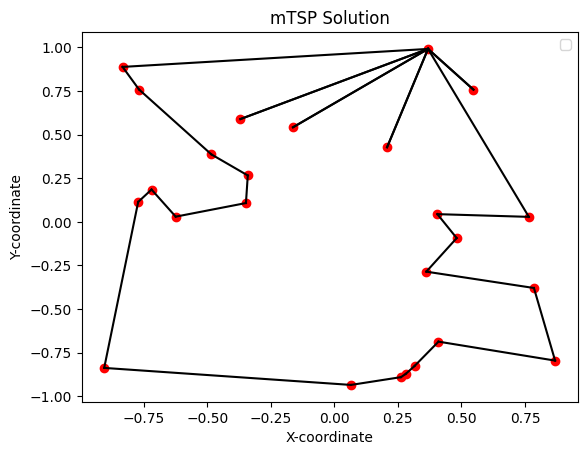

In [72]:
# Now, the fun part, let's visualize:

import matplotlib.pyplot as plt

# Extract solution values
solution = opt_model.getAttr('X', x_vars)
routes = [(i, j) for i, j in solution if solution[i, j] > 0.5]

# Extract u_vars values
node_order = [int(re.search(r'\d+', var.VarName).group()) for var in u_vars.values()]
order_dict = dict(zip(range(n_cities), node_order))

# Sort routes by order
sorted_routes = sorted(routes, key=lambda x: order_dict[x[0]])

# Plot the cities
for i, (x, y) in enumerate(points):
    plt.plot(x, y, 'o', color='red')

# Plot the routes
for i, j in sorted_routes:
    plt.plot([points[i][0], points[j][0]],
             [points[i][1], points[j][1]], 'k-')

plt.title('mTSP Solution')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()